In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from gensim.models import KeyedVectors
from adjustText import adjust_text
import multiprocessing as mp
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pyarrow as pa
import pyarrow.parquet as pq

In [3]:
%run helper_functions

In [4]:
data_path = "./data/"

In [5]:
annotation_data = pd.read_parquet(data_path + 'annotation_data.parquet')

In [6]:
df_tok1 = pd.read_parquet('./data/data_speech1_tok.parquet')
df_tok2 = pd.read_parquet('./data/data_speech2_tok.parquet')
df = pd.concat([df_tok1, df_tok2]).reset_index(drop=True)

Choose speech items from annotated agenda items

In [7]:
anno_tokens = pd.merge(df, annotation_data[["meeting_id","agenda_item_id","label"]], on=["meeting_id","agenda_item_id"])
anno_tokens.rename(columns={'label':'label_agenda',"tokenized_speech":"speech_item_tokenized"},inplace=True)
anno_tokens["speech_item_tokenized"] = anno_tokens["speech_item_tokenized"].apply(lambda x: eval(x))

### Calculate Odds


In [8]:
df_C = anno_tokens[anno_tokens['label_agenda']=='C']
df_NC = anno_tokens[anno_tokens['label_agenda']=='NC']

unique_words_C_list = [word for tokens in df_C.speech_item_tokenized for word in tokens]
unique_words_NC_list = [word for tokens in df_NC.speech_item_tokenized for word in tokens]

unique_words_C_dict = Counter(unique_words_C_list)
unique_words_NC_dict = Counter(unique_words_NC_list)

unique_words_C_df = pd.DataFrame.from_dict(unique_words_C_dict, orient='index', columns=['word_count_C']).reset_index().rename(columns={'index': 'word'})
unique_words_NC_df = pd.DataFrame.from_dict(unique_words_NC_dict, orient='index', columns=['word_count_NC']).reset_index().rename(columns={'index': 'word'})

#merge
unique_words = pd.merge(unique_words_C_df, unique_words_NC_df, on='word', how='outer')
unique_words[['word_count_C', 'word_count_NC']] = unique_words[['word_count_C', 'word_count_NC']].fillna(0)
unique_words['frequency_C'] = unique_words['word_count_C'] / sum(unique_words_C_df['word_count_C'])
unique_words['frequency_NC'] = unique_words['word_count_NC'] / sum(unique_words_NC_df['word_count_NC'])
freq_1_NC = unique_words[unique_words['word_count_NC']==1]['frequency_NC'].iloc[0]
freq_1_C = unique_words[unique_words['word_count_C']==1]['frequency_C'].iloc[0]

unique_words["odds_C"] = unique_words.apply(lambda row: calculate_odds(row['frequency_C'], row['frequency_NC'], 'C', freq_1_NC), axis=1)
unique_words["odds_NC"] = unique_words.apply(lambda row: calculate_odds(row['frequency_NC'], row['frequency_C'], 'NC', freq_1_C), axis=1)


## Make Percentiles

In [9]:
unique_words['rank_odds_C'] = unique_words['odds_C'].rank(ascending=False)
unique_words['rank_odds_NC'] = unique_words['odds_NC'].rank(ascending=False)

In [10]:
unique_words_above_1_C = unique_words[(unique_words['odds_C'] > 1) & (unique_words['frequency_C'] > 0.0001)]
                          
unique_words_above_1_C['rank'] = unique_words_above_1_C['odds_C'].rank(method='first')
unique_words_above_1_C['odds_C_percentile'] = unique_words_above_1_C['rank'].apply(lambda x: map_rank_to_bin(unique_words_above_1_C, x))

unique_words_above_1_NC = unique_words[(unique_words['odds_NC'] > 1) & (unique_words['frequency_NC'] > 0.0001)]
unique_words_above_1_NC['rank'] = unique_words_above_1_NC['odds_NC'].rank(method='first')
unique_words_above_1_NC['odds_NC_percentile'] = unique_words_above_1_NC['rank'].apply(lambda x: map_rank_to_bin(unique_words_above_1_NC, x))

## Adding DSL word-to-vec, choosing Odds, k-means, and cosine similarities

In [11]:
# download the model from here: https://korpus.dsl.dk/resources/licences/dsl-open.html#en
# please change the path to the model file accordingly
MODEL_FILE = '~/Desktop/dsl_skipgram_2020_m5_f500_epoch2_w5.model.w2v.bin'
word_vec_model = KeyedVectors.load_word2vec_format(MODEL_FILE, binary=True)

In [12]:
df_percentiles = pd.DataFrame(columns=['percentile', 'perplexity', 'prop_c_not_in_group_c', 'prop_nc_not_in_group_nc', 'cosine_similarities_C', 'cosine_similarities_NC'])

# generate different dataframes with different odds

for percentile in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]:
    data = choose_odds_percentiles(percentile,unique_words_above_1_C,unique_words_above_1_NC,word_vec_model)
    
    data = k_means(data, 2, perplex=20)
    k_means_group_c = data[data['label']=='C']['k_means_group_tsne'].value_counts().idxmax()
    data['k_means_group_tsne'] = np.where(data['k_means_group_tsne'] == k_means_group_c, 'C', 'NC')
    prop_c_not_in_group_c = len(data[(data['label']=='C') & (data['k_means_group_tsne'] == 'NC')]) / len(data[data['label']=='C'])
    prop_nc_not_in_group_nc = len(data[(data['label']=='NC') & (data['k_means_group_tsne'] == 'C')]) / len(data[data['label']=='NC'])

    cosine_similarities_C = cosine_similarities(data, 'C', word_vec_model)
    cosine_similarities_NC = cosine_similarities(data, 'NC', word_vec_model)

    data_df = pd.DataFrame({
        'percentile': [percentile],
        'perplexity': [20],
        'prop_c_not_in_group_c': [prop_c_not_in_group_c],
        'prop_nc_not_in_group_nc': [prop_nc_not_in_group_nc],
        'cosine_similarities_C': [cosine_similarities_C],
        'cosine_similarities_NC': [cosine_similarities_NC]
    })

    df_percentiles = pd.concat([df_percentiles, data_df], ignore_index=True)

In [40]:
percentile_18C = round(unique_words_above_1_C[unique_words_above_1_C['odds_C_percentile']==18]['odds_C'].min(),1 )
percentile_18NC = round(unique_words_above_1_NC[unique_words_above_1_NC['odds_NC_percentile']==18]['odds_NC'].min(),1 )

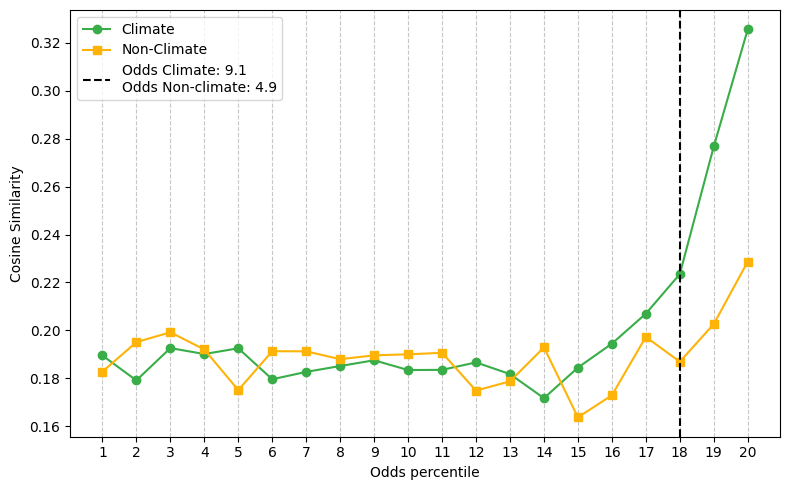

In [51]:
plt.figure(figsize=(8, 5))
plt.plot(df_percentiles['percentile'], df_percentiles['cosine_similarities_C'], marker='o', label='Climate', color = sns.xkcd_rgb['medium green'])
plt.plot(df_percentiles['percentile'], df_percentiles['cosine_similarities_NC'], marker='s', label='Non-Climate', color=sns.xkcd_rgb['amber'])
plt.grid(True, which='both', axis='x', linestyle='--', alpha=0.7)
plt.axvline(x=18, color='black', linestyle='--', label= f'Odds Climate: {percentile_18C} \nOdds Non-climate: {percentile_18NC}')
plt.xticks(list(range(1, 21)))
plt.legend()
plt.xlabel('Odds percentile')
plt.ylabel('Cosine Similarity')
plt.tight_layout()
plt.savefig('./figures/odds_percentile.svg', format='svg')

In [ ]:
def plot_k_means_C(df):
    plt.figure(figsize=(16, 12))
    df = df[df['label']=='C']
    df['label_numeric'] = pd.Categorical(df['classification']).codes
    colors = ['b', 'c', 'y', 'm']
    scatter_TP = plt.scatter(x=df[df['classification']=='TP']['embedded_data1'], y=df[df['classification']=='TP']['embedded_data2'], marker='o', color=colors[0], s = 4)
    scatter_FN = plt.scatter(x=df[df['classification']=='FN']['embedded_data1'], y=df[df['classification']=='FN']['embedded_data2'], marker='x', color=colors[3], s = 4)
    
    texts = [plt.text(row['embedded_data1'], row['embedded_data2'], row['word'], fontsize=6, ha='right') for i, row in df.iterrows()]

    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'), force_text=0.5, force_points=0.5)
    
    plt.legend((scatter_TP, scatter_FN),
           ('True positive', 'False negative'),
           loc='upper right',
           fontsize=12)
    
    plt.savefig('plotC.svg', format='svg')

    plt.show()

In [ ]:
percentile_85 = pd.concat([choose_odds_percentiles(18,unique_words_above_1_C,unique_words_above_1_NC,word_vec_model),
                           choose_odds_percentiles(19,unique_words_above_1_C,unique_words_above_1_NC,word_vec_model), 
                           choose_odds_percentiles(20,unique_words_above_1_C,unique_words_above_1_NC,word_vec_model)])
percentile_85 = k_means(percentile_85, 2, perplex=20)
k_means_group_c = percentile_85[percentile_85['label']=='C']['k_means_group_tsne'].value_counts().idxmax()
percentile_85['k_means_group_tsne'] = np.where(percentile_85['k_means_group_tsne'] == k_means_group_c, 'C', 'NC')

percentile_85['classification'] = np.where(
    (percentile_85['label'] == 'C') & (percentile_85['k_means_group_tsne'] == 'C'), 'TP',
    np.where((percentile_85['label'] == 'NC') & (percentile_85['k_means_group_tsne'] == 'NC'), 'TN',
             np.where((percentile_85['label'] == 'C') & (percentile_85['k_means_group_tsne'] == 'NC'), 'FN', 'FP')))

plot_k_means_C(percentile_85)

### Manually check wordlists

In [ ]:
#use 95 percentiles to find shared common words
data_C = unique_words.loc[unique_words["word_count_C"] > 0, 'frequency_C']
percentile_95_C = np.percentile(data_C, 95)

data_NC = unique_words.loc[unique_words["word_count_NC"] > 0, 'frequency_NC']
percentile_95_NC = np.percentile(data_NC, 95)

In [ ]:
generic_words_list = unique_words[(unique_words.frequency_C>percentile_95_C)&(unique_words.frequency_NC>percentile_95_NC)& 
                                  (unique_words.odds_C > 0.9) & (unique_words.odds_C < 1.1) &
                                  (unique_words.odds_NC > 0.9) & (unique_words.odds_NC < 1.1)].word.to_list()

In [ ]:
# with open('C_TP.txt', 'w',  encoding='utf-8') as file:
#     for item in percentile_85[percentile_85['classification']=='TP']['word'].tolist():
#         file.write(str(item) + '\n')
        
    
# with open('C_FN.txt', 'w', encoding='utf-8') as file:
#     for item in percentile_85[percentile_85['classification']=='FN']['word'].tolist():
#         file.write(str(item) + '\n')

# with open('NC.txt', 'w', encoding='utf-8') as file:
#     for item in percentile_85[percentile_85['label']=='NC']['word'].tolist():
#         file.write(str(item) + '\n')      

# with open('./data/word_lists/word_list_generic.txt', 'w', encoding='utf-8') as file:
#     for item in generic_words_list:
#         file.write(str(item) + '\n')




### Add odds to words

In [ ]:
word_list_C = pd.read_csv('C_TP.txt', index_col = None)
word_list_C = pd.merge(word_list_C, percentile_85[['word', 'odds_C']], on = 'word', how = 'left')
#word_list_C.to_parquet('./data/word_lists/word_list_C.parquet')

In [ ]:
word_list_NC = pd.read_csv('NC.txt', index_col = None)
word_list_NC = pd.merge(word_list_NC, percentile_85[['word', 'odds_NC']], on = 'word', how = 'left')
#word_list_NC.to_parquet('./data/word_lists/word_list_NC.parquet')